In [1]:
import sys
sys.path.append("../lropy")

%load_ext autoreload
%autoreload complete

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import pandas as pd
import numpy as np
import seaborn as sb
import spiceypy as spice

from datetime import datetime, timedelta, timezone
from pathlib import Path

In [3]:
from lropy.analysis.spice_tools import as_et, as_utc, as_tdb, generate_lro_ephemeris
from lropy.analysis.io import load_simulation_results, load_all_simulation_results, load_pickled_simulation_results, pos_names, vel_names, acc_names, irr_names, panels_count_names
from lropy.analysis.plotting import format_plot, save_plot
from lropy.analysis.transform import spher2cart, cart2spher, align_vectors
from lropy.analysis.util import get_day_index, trim_df, get_revolutions_index
from lropy.constants import moon_polar_radius

In [4]:
def plot_accelerations(dfs, labels, sources=None):
    fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex="all")
    ax_mag, ax_radial, ax_along, ax_cross = axs

    if sources is None:
        sources = ["moon"] * len(dfs)

    for df, label, source in zip(dfs, labels, sources):
        ax_mag.plot(df.index, df[f"acc_rp_{source}"], label=label)
        ax_radial.plot(df.index, df[f"acc_rp_{source}_radial"])
        ax_along.plot(df.index, df[f"acc_rp_{source}_along"])
        ax_cross.plot(df.index, df[f"acc_rp_{source}_cross"])

    ax_mag.set_title("magnitude")
    ax_radial.set_title("radial")
    ax_along.set_title("along")
    ax_cross.set_title("cross")
    ax_mag.legend()

    for ax in axs.flat:
        ax.tick_params(axis='x', labelrotation=45)
        ax.set_ylim([min(0, ax.get_ylim()[0]), ax.get_ylim()[1]])
        ax.ticklabel_format(axis="y", style="sci", scilimits=(-9, -9), useMathText=True)
    
    format_plot(major_grid=True)

# Effect of instantaneous reradiation

In [5]:
results_folder_rerad = Path("../results/instantaneous_reradiation_test-2023-08-19T11-39-01-0e203")
metadata_rerad, runs_rerad = load_pickled_simulation_results(results_folder_rerad)

In [6]:
metadata_rerad

id hostname             start_timestamp  \
1  a6501  eudoxos  2023-08-19T11:39:01.826573   
2  620ca  eudoxos  2023-08-19T11:39:01.826615   
3  99f1c  eudoxos  2023-08-19T11:39:01.826633   
4  7daaa  eudoxos  2023-08-19T11:39:01.826647   
5  2f92b  eudoxos  2023-08-19T11:39:01.826659   
6  df97a  eudoxos  2023-08-19T11:39:01.826671   

                                            save_dir      simulation_start  \
1  /home2/dominik/dev/lropy/results/instantaneous...  2011 SEP 26 18:00:00   
2  /home2/dominik/dev/lropy/results/instantaneous...  2010 JUN 28 15:00:00   
3  /home2/dominik/dev/lropy/results/instantaneous...  2010 JUN 28 15:00:00   
4  /home2/dominik/dev/lropy/results/instantaneous...  2011 SEP 26 18:00:00   
5  /home2/dominik/dev/lropy/results/instantaneous...  2010 JUN 28 15:00:00   
6  /home2/dominik/dev/lropy/results/instantaneous...  2011 SEP 26 18:00:00   

  target_type with_instantaneous_reradiation use_occultation  \
1     Paneled                          False            True   
2     Paneled                          False            True   
3     Paneled                           True            True   
4     Paneled                           True            True   
5     Paneled                          False            True   
6     Paneled                          False            True   

  use_solar_radiation use_moon_radiation paneling_moon number_of_panels_moon  \
1                True               True       Dynamic                     0   
2                True               True       Dynamic                     0   
3                True               True       Dynamic                     0   
4                True               True       Dynamic                     0   
5               False              False                                   0   
6               False              False                                   0   

  number_of_panels_per_ring_moon albedo_distribution_moon thermal_type_moon  \
1        [6, 12, 18, 24, 30, 36]                 Constant        AngleBased   
2        [6, 12, 18, 24, 30, 36]                 Constant        AngleBased   
3        [6, 12, 18, 24, 30, 36]                 Constant        AngleBased   
4        [6, 12, 18, 24, 30, 36]                 Constant        AngleBased   
5                             []                                              
6                             []                                              

  simulation_duration step_size save_results walltime_propagation  \
1             13563.4         5         True            18.353597   
2             13563.4         5         True            18.145782   
3             13563.4         5         True            18.491977   
4             13563.4         5         True            20.110302   
5             13563.4         5         True            14.352405   
6             13563.4         5         True            14.338987   

         walltime_total  
1   [19.10147862136364]  
2  [18.886169772595167]  
3  [19.242287643253803]  
4  [20.855859387665987]  
5  [15.073216816410422]  
6  [15.063640976324677]

In [7]:
def plot_rp(source, start_date):
    fig, axs = plt.subplots(4, figsize=(12, 7))

    df_with_rerad = runs_rerad[
        metadata_rerad[
            (metadata_rerad["simulation_start"] == start_date) &
            metadata_rerad["use_moon_radiation"] &
            metadata_rerad["use_solar_radiation"] &
            metadata_rerad["with_instantaneous_reradiation"].astype(bool)
    ].index[0]]
    df_without_rerad = runs_rerad[
        metadata_rerad[
            (metadata_rerad["simulation_start"] == start_date) &
            metadata_rerad["use_moon_radiation"] &
            metadata_rerad["use_solar_radiation"] &
            ~metadata_rerad["with_instantaneous_reradiation"].astype(bool)
    ].index[0]]

    for comp, ax in zip(["magnitude", "radial", "along", "cross"], axs):
        ax.set_title(comp)

        if comp == "magnitude":
            col = f"acc_rp_{source}"
        else:
            col = f"acc_rp_{source}_{comp}"

        ax.plot(get_revolutions_index(df_without_rerad), df_without_rerad[col], label="Without instantaneous reradiation", zorder=3)
        ax.plot(get_revolutions_index(df_with_rerad), df_with_rerad[col], label="With instantaneous reradiation", zorder=4)
        ax.plot(get_revolutions_index(df_with_rerad), df_with_rerad[col] * df_without_rerad[col].abs().max() / df_with_rerad[col].abs().max(), label="With instantaneous reradiation (scaled))", c="C1", alpha=0.5, zorder=2)
    
    for ax in axs.flat:
        ax.ticklabel_format(axis="y", style="sci", scilimits=(-9, -9), useMathText=True)
        ax.set_ylim([min(0, ax.get_ylim()[0]), max(0, ax.get_ylim()[1])])

    axs[0].legend()

    format_plot(major_grid=True, minor_grid=True)

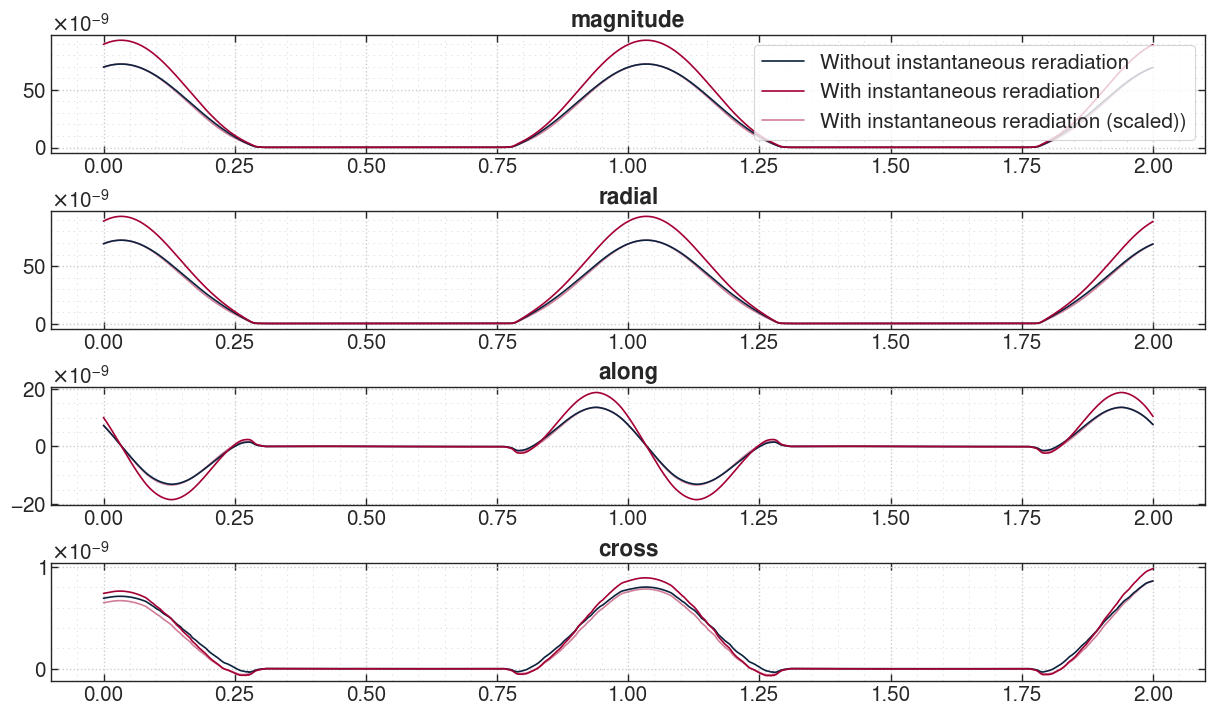

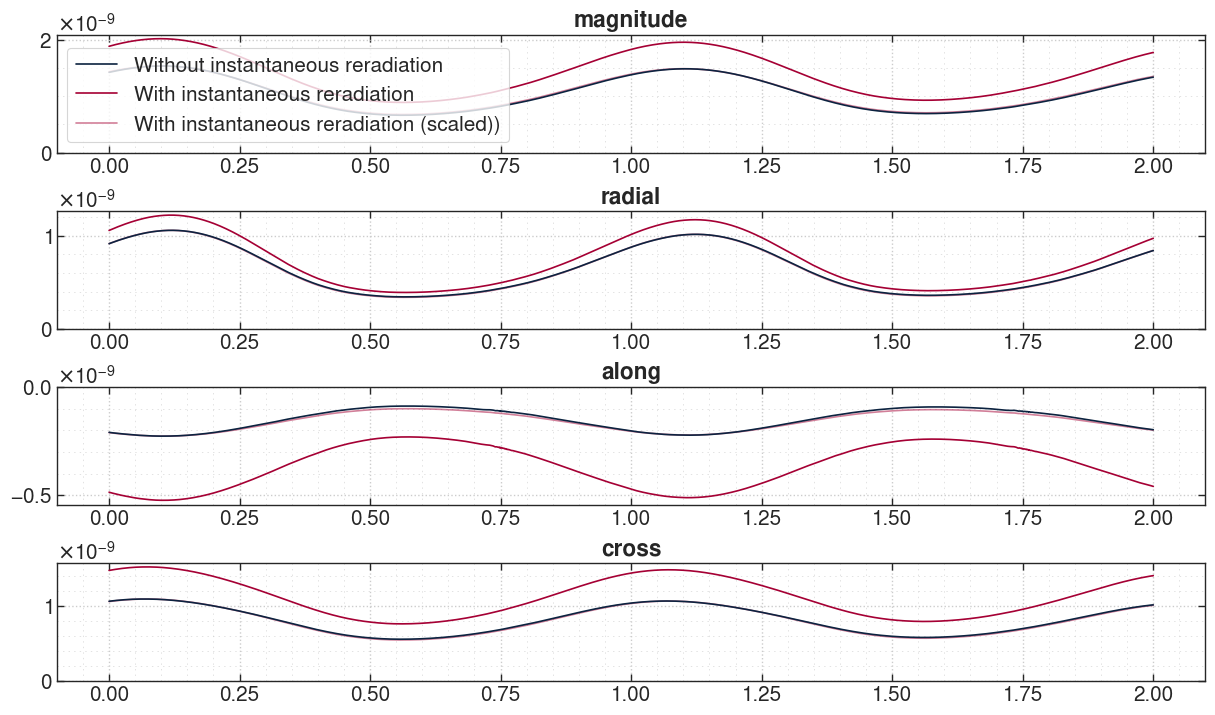

In [8]:
plot_rp("moon", "2011 SEP 26 18:00:00")
plot_rp("moon", "2010 JUN 28 15:00:00")

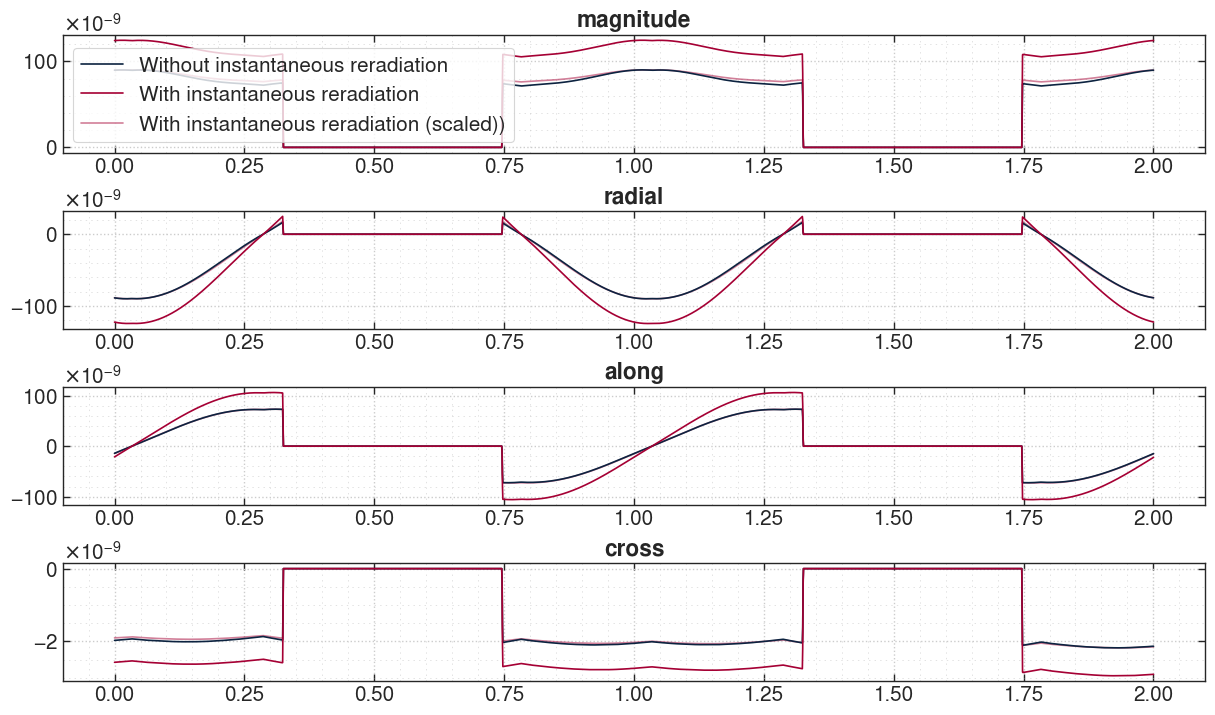

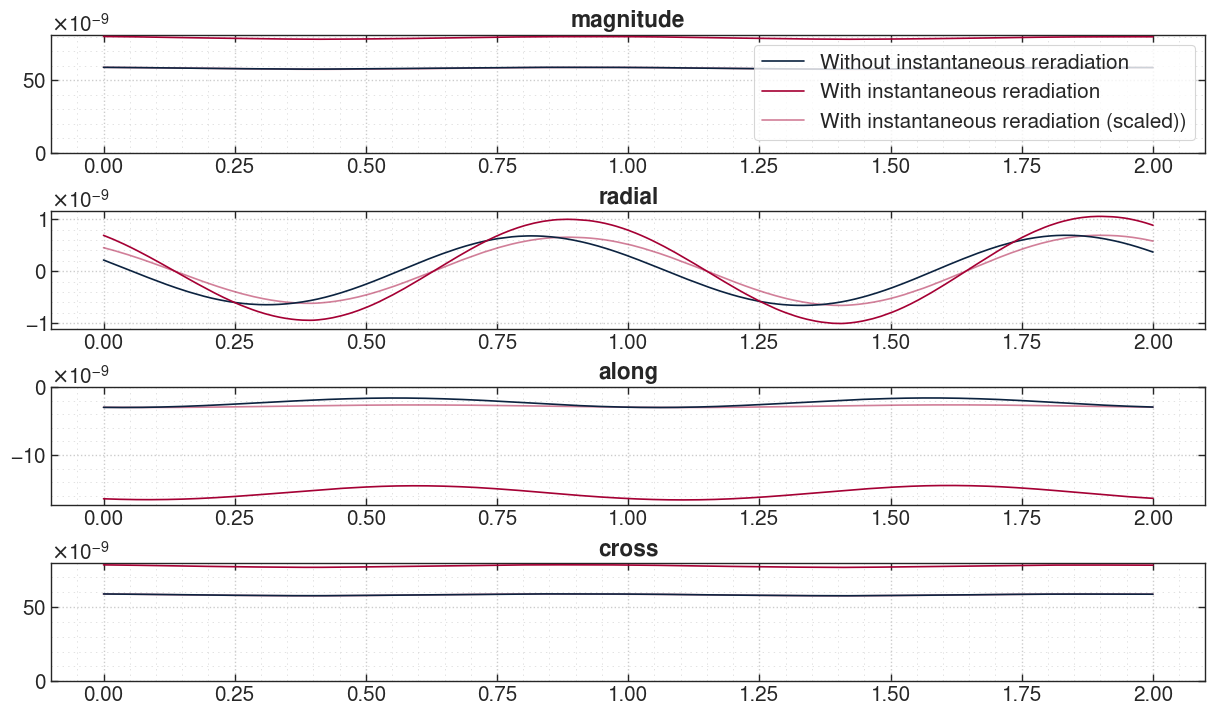

In [9]:
plot_rp("sun", "2011 SEP 26 18:00:00")
plot_rp("sun", "2010 JUN 28 15:00:00")

Shape of both is slightly different, i.e. instantaneous reradiation is not simply a factor.

# Relative contribution of albedo and thermal

In [44]:
results_folder_contribs = Path("../results/albedo_thermal_test-2023-08-30T09-52-32-f803f")
# results_folder_contribs = Path("../results/albedo_thermal_test-2023-08-19T11-39-46-c9586")
metadata_contribs, runs_contribs = load_pickled_simulation_results(results_folder_contribs)

In [45]:
metadata_contribs

id               hostname             start_timestamp  \
1   d8f10  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496101   
2   149b7  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496128   
3   1862b  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496143   
4   4e108  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496155   
5   d8901  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496166   
6   fb054  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496177   
7   b40bb  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496190   
8   9f8f3  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496204   
9   7ec52  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496216   
10  c59cf  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496226   
11  3d279  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496236   
12  9dc76  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496244   
13  5a68b  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496253   
14  444eb  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496262   
15  1ee63  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496270   
16  83df9  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496278   
17  81658  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496286   
18  a615b  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496294   
19  39f29  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496302   
20  9186c  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496310   
21  7c14c  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496318   
22  6c1af  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496325   
23  fdd0d  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496333   
24  9ac7f  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496342   
25  d15ee  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496350   
26  3b50d  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496362   
27  03693  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496371   
28  86644  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496379   
29  6be74  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496386   
30  f49bf  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496394   
31  e427c  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496405   
32  a5fe9  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496413   
33  a877c  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496421   
34  40195  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496429   
35  a0664  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496437   
36  2ad91  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496445   
37  a8fb7  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496453   
38  61265  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496460   
39  94d5b  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496468   
40  94ae3  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496476   
41  1c0f1  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496485   
42  b4d45  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496493   
43  be43c  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496500   
44  fbe89  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496508   
45  09c38  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496516   
46  982d8  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496524   
47  ef0b2  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496532   
48  cad58  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496540   
49  ee617  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496548   
50  5112a  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496556   
51  dc989  eudoxos.lr.tudelft.nl  2023-08-30T09:52:32.496564   

                                             save_dir      simulation_start  \
1   /home2/dominik/dev/hpb-project/results/albedo_...  2010 JUN 28 15:00:00   
2   /home2/dominik/dev/hpb-project/results/albedo_...  2010 JUN 28 15:00:00   
3   /home2/dominik/dev/hpb-project/results/albedo_...  2010 JUN 28 15:00:00   
4   /home2/dominik/dev/hpb-project/results/albedo_...  2011 SEP 26 18:00:00   
5   /home2/dominik/dev/hpb-project/results/albedo_...  2011 SEP 26 18:00:00   
6   /home2/dominik/dev/hpb-project/results/albedo_...  2011 SEP 26 18:00:00   
7   /home2/dominik/dev/hpb-project/results/albedo_...  2010 JUN 28 15:00:00   
8   /home2/dominik/dev/hpb-project/results/alb

In [46]:
def get_contrib_run(albedo, thermal, target_type, start_date):
    for date in metadata_contribs["simulation_start"].unique():
        if date.startswith(start_date):
            start_date = date
            break

    idx = metadata_contribs[
        (metadata_contribs["albedo_distribution_moon"] == albedo) &
        (metadata_contribs["thermal_type_moon"] == thermal) &
        (metadata_contribs["target_type"] == target_type) &
        (metadata_contribs["simulation_start"] == start_date)
    ]
    if len(idx.index) > 1:
        raise ValueError("More than one run found")
    return runs_contribs[idx.index[0]]

### Orbital period

6778.992000500103 6785.467239935397 6781.62583700388 113.027097283398


6779.689952703389 6788.937565347784 6784.4169174640265 113.07361529106711


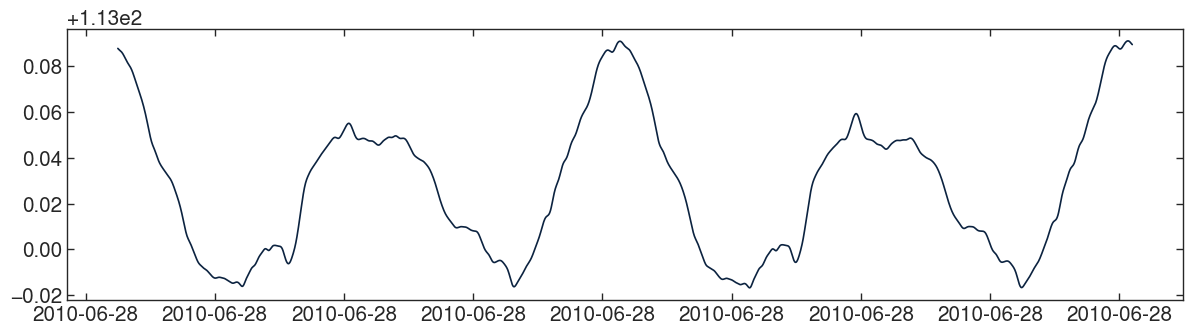

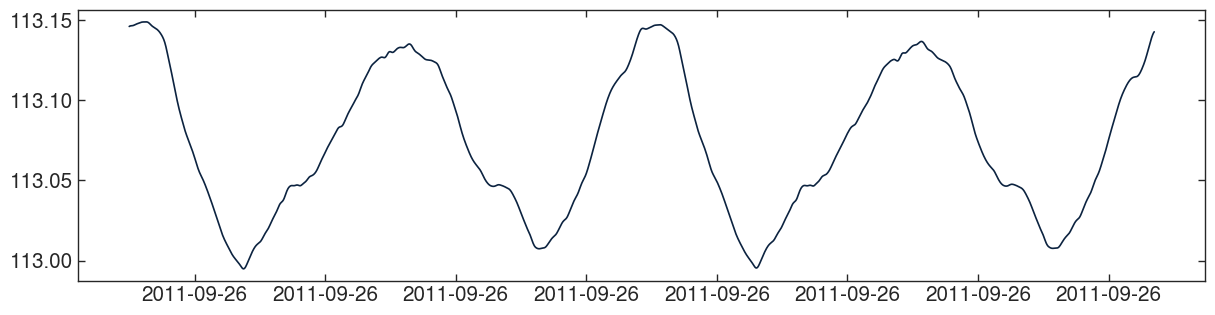

In [47]:
def plot_orbital_period(date):
    gm_moon = 4.9048695e12
    df = get_contrib_run("DLAM1", "AngleBased", "Paneled", date)

    period = np.sqrt(df["kepler_a"]**3 / gm_moon) * 2 * np.pi
    print(period.min(), period.max(), period.mean(), period.mean() / 60)

    plt.subplots()
    plt.plot(df.index, period / 60)

    format_plot()

plot_orbital_period("2010 JUN 28")
plot_orbital_period("2011 SEP 26")

### Solar vs lunar albedo

Expected solar RP acceleration from Lucchesi (2006) Eq. 2:

In [48]:
distance_moon_sun = 152460762e3  # m
sun_luminosity = 3.828e26  # W
solar_irradiance = sun_luminosity / (4 * np.pi * distance_moon_sun**2)
c = 299792458  # m/s
radiation_pressure = solar_irradiance / c

14.0 / 1087 * 1.0 * radiation_pressure

5.630198174778997e-08

which agrees with Smith's results and ours for cannonball (with mass 1208 and area 11.5 m2). Our paneled results correspond to a cannonball coefficient of 1.6, which can occur (Mazarico 2018, Fig. 15).

Expected albedo RP acceleration from Lucchesi (2006) Eq. 17:

In [49]:
0.15 / 2 * (moon_polar_radius / (moon_polar_radius + 50))**2 * 5.63e-8

4.2222567789410525e-09

which agrees with our results, not Smiths.
* Factor 1/2 in expected albedo RP probably due to ratio 1/2 of visible projected disk area to irradiated hemisphere area

55.40097250164087
5.6905222292026577e-08
0.0 1324.56823402342
55.40097250164087
5.6905222292026577e-08
0.0 1324.56823402342


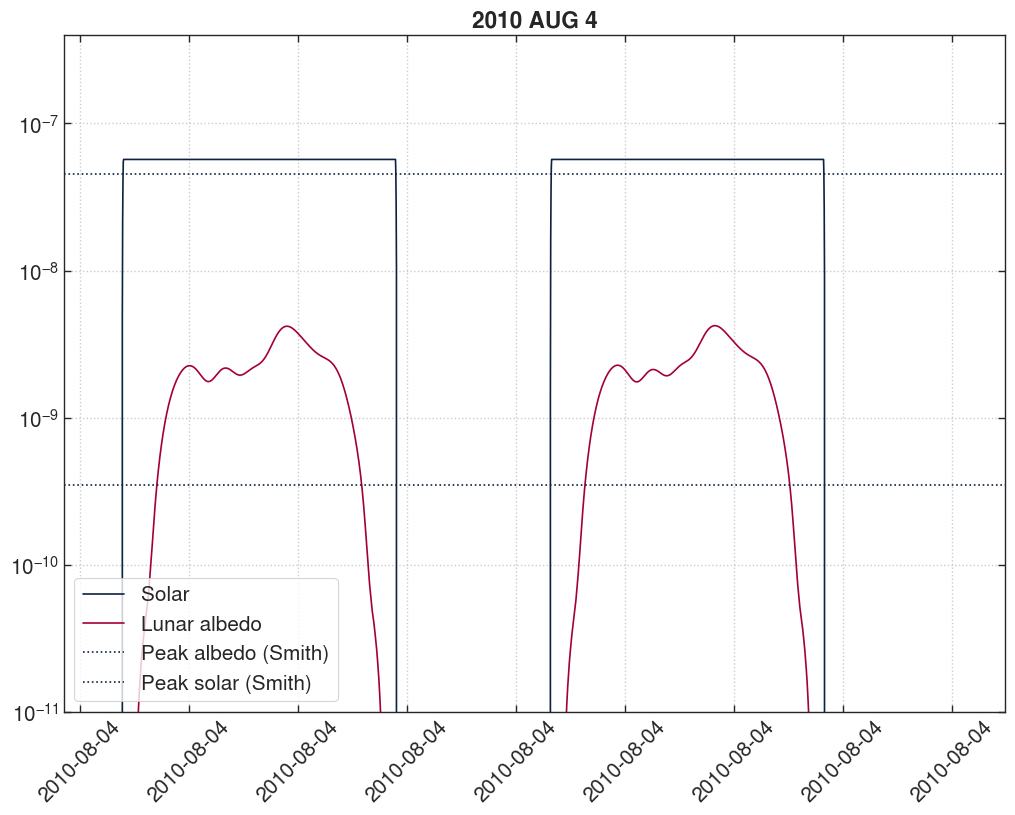

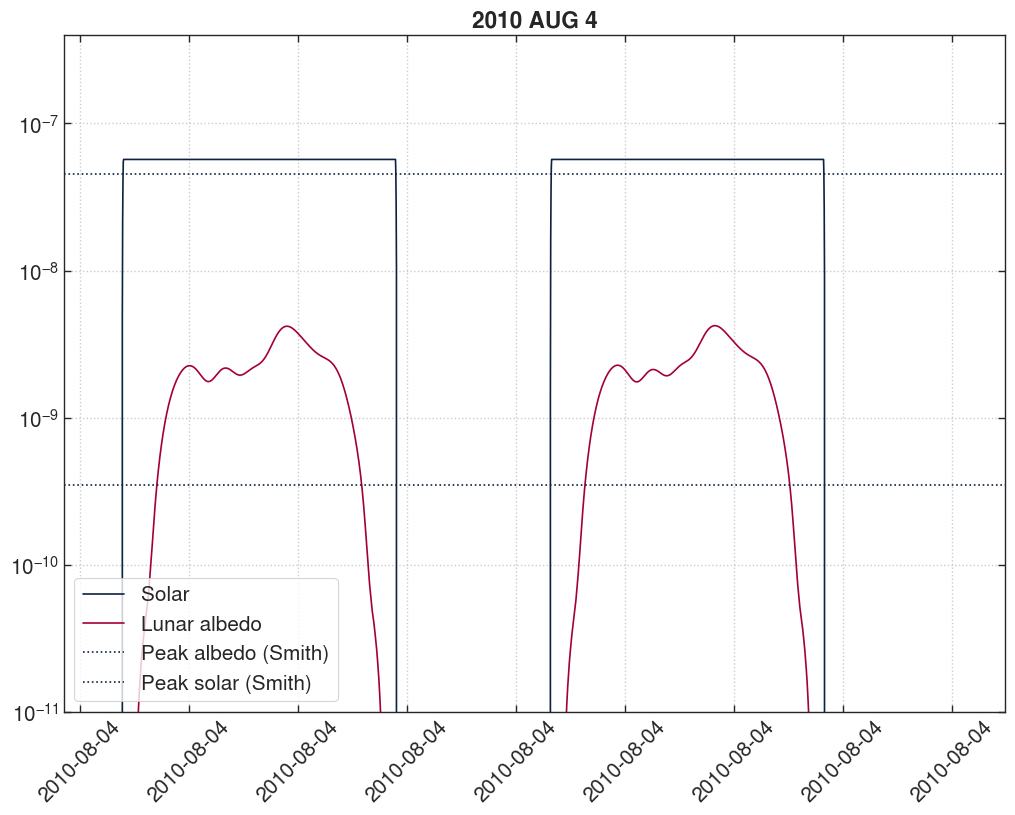

In [70]:
def plot_solar_vs_albedo(start_date):
    start_date = "2010 AUG 4"
    df = get_contrib_run("DLAM1", "NoThermal", "Cannonball", start_date)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8), sharex="all")

    ax.plot(df.index, df["acc_rp_sun"], label="Solar")
    ax.plot(df.index, df["acc_rp_moon"], label="Lunar albedo")
    print(df["angle_subsolar"].min())
    print(df["acc_rp_sun"].max())
    print(df["irr_sun"].min(), df["irr_sun"].max())

    ax.axhline(3.5e-10, label="Peak albedo (Smith)", ls=":")
    ax.axhline(4.5e-8, label="Peak solar (Smith)", ls=":")

    ax.legend()
    ax.set_title(start_date)

    ax.tick_params(axis='x', labelrotation=45)
    ax.set_ylim([1e-11, 4e-7])
    ax.set_yscale("log")
    
    format_plot(major_grid=True)

plot_solar_vs_albedo("2010 AUG 4")
plot_solar_vs_albedo("2011 SEP 26")

Considerations for finding arc from Smith (2008):
* In their figure, 64% of orbit is not eclipsed. This occurs around August 4. Around August 29, 59% of the orbit is not eclipsed.
* February arc with 64% non-eclipse has very different albedo behavior -> must be August 4

### DLAM-1 vs constant albedo

In [51]:
def plot_albedo_type(start_date):
    df_albedo_constant = get_contrib_run("Constant", "NoThermal", "Cannonball", start_date)
    df_albedo_dlam = get_contrib_run("DLAM1", "NoThermal", "Cannonball", start_date)
    plot_accelerations([df_albedo_constant, df_albedo_dlam], ["Constant", "DLAM-1"])

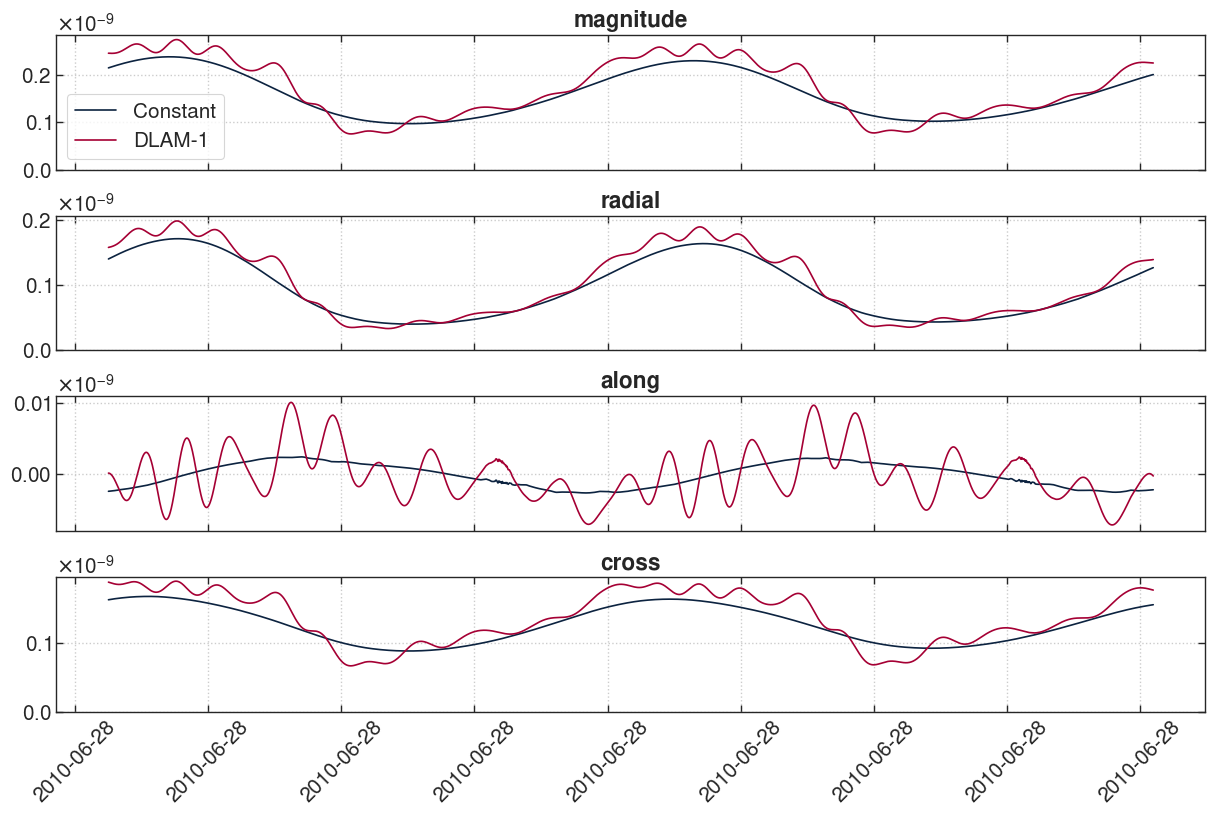

In [52]:
plot_albedo_type("2010 JUN 28")

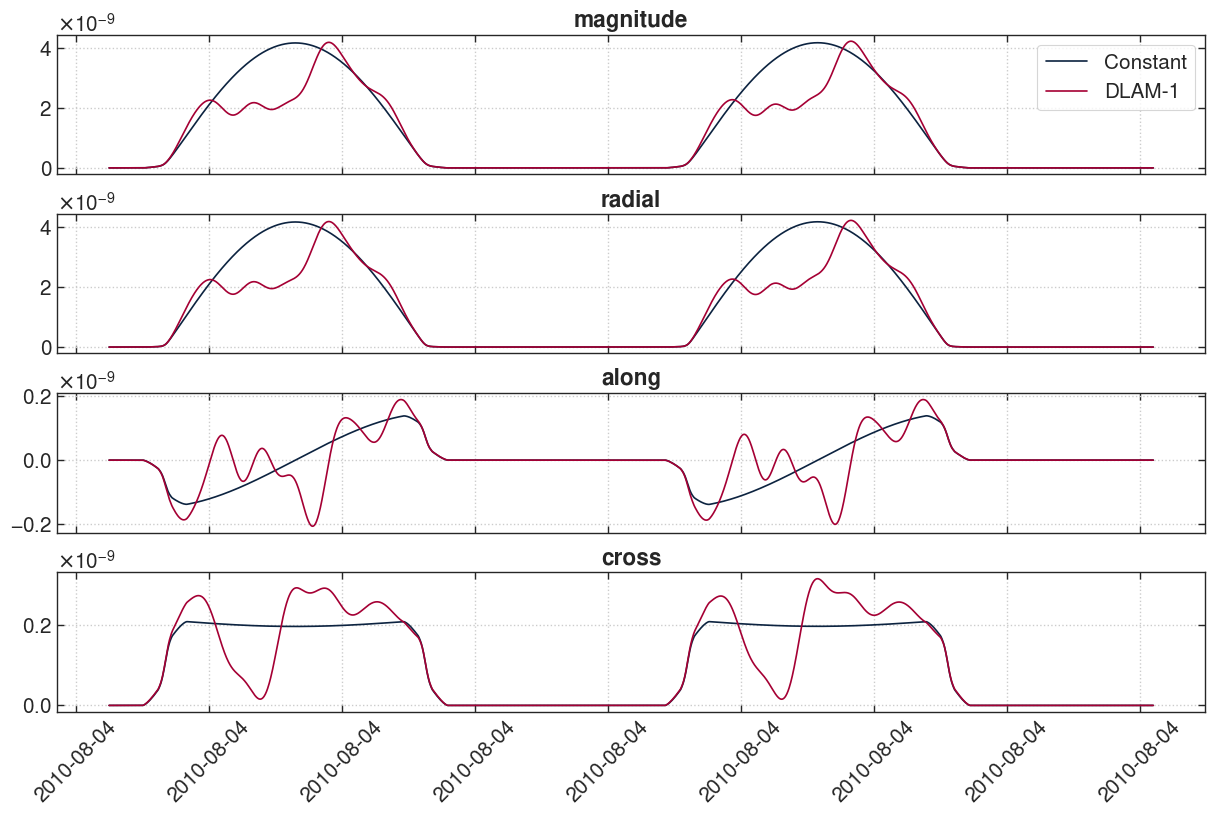

In [71]:
plot_albedo_type("2010 AUG 4")

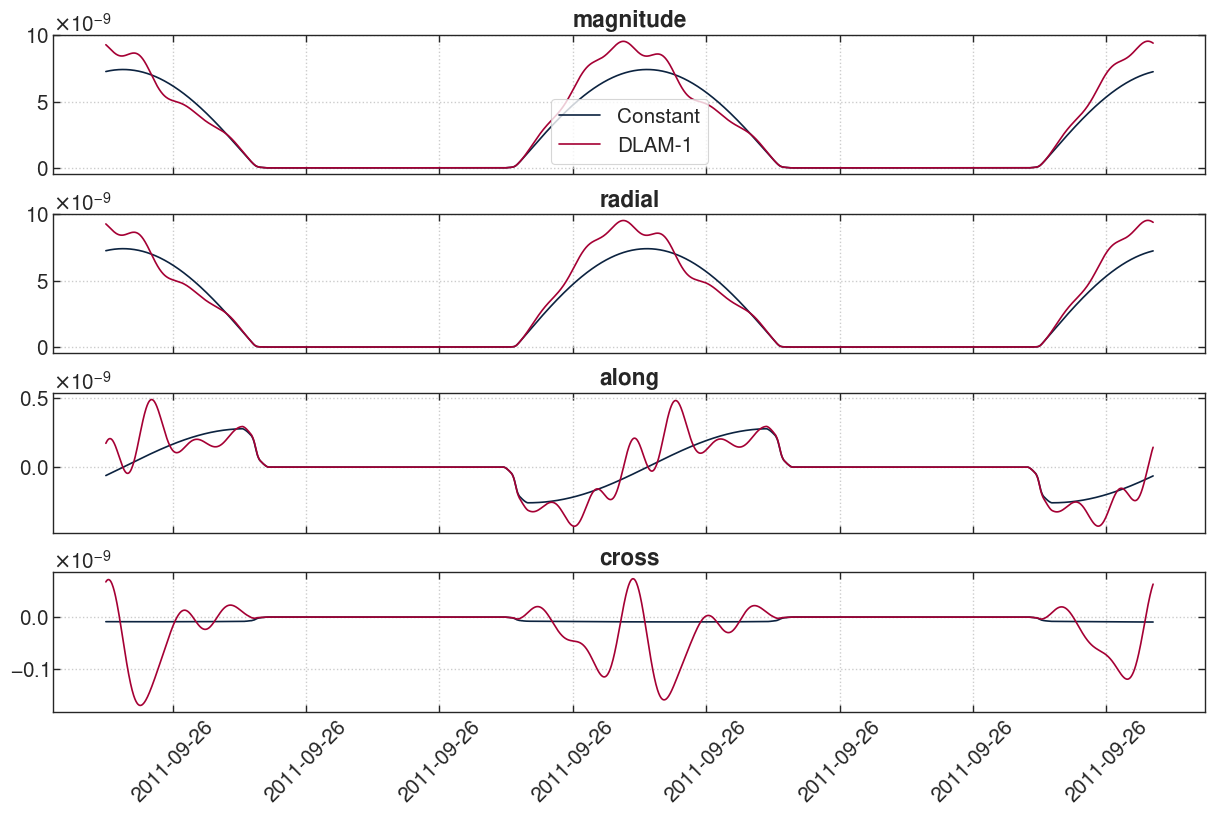

In [53]:
plot_albedo_type("2011 SEP 26")

### Delayed vs angle-based thermal radiation

In [54]:
def plot_thermal_type(start_date):
    df_albedo_angle_based = get_contrib_run("NoAlbedo", "AngleBased", "Cannonball", start_date)
    df_albedo_delayed = get_contrib_run("NoAlbedo", "Delayed", "Cannonball", start_date)
    plot_accelerations([df_albedo_angle_based, df_albedo_delayed], ["Angle-based", "Delayed"])

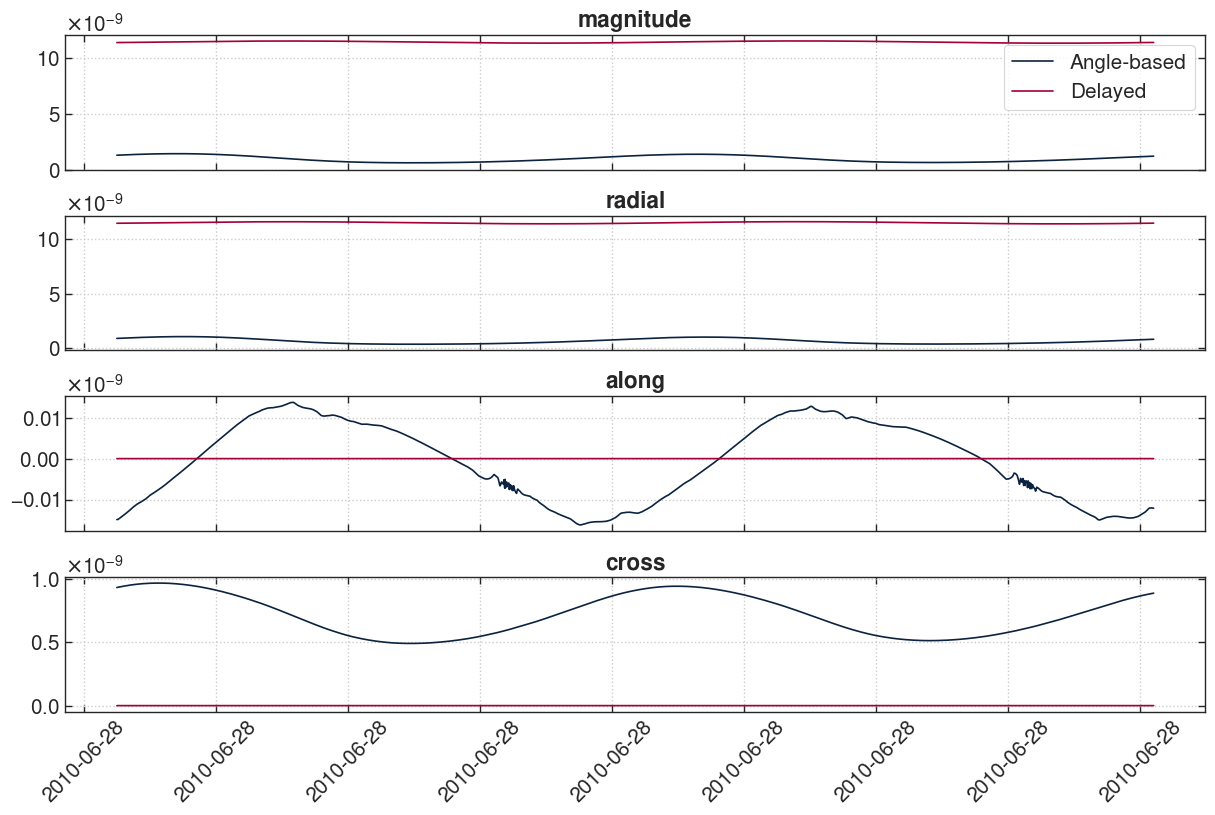

In [55]:
plot_thermal_type("2010 JUN 28")

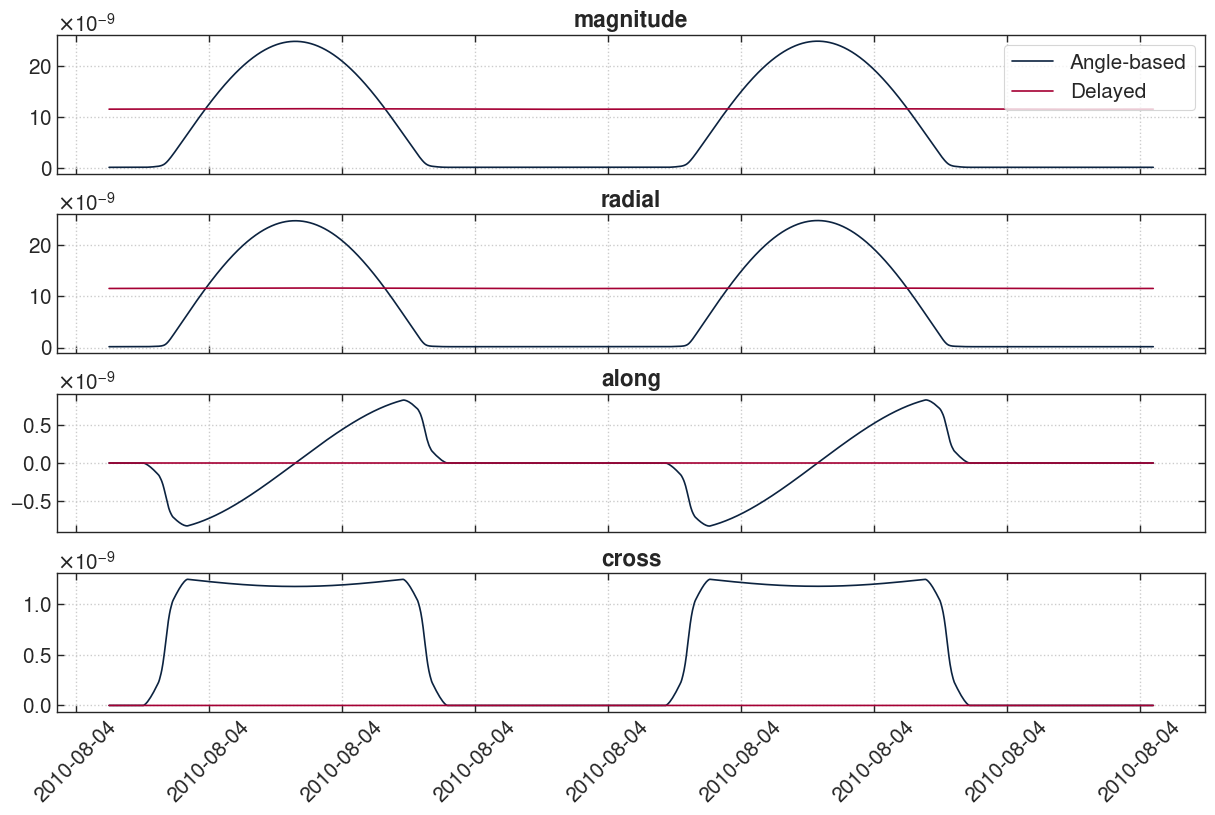

In [72]:
plot_thermal_type("2010 AUG 4")

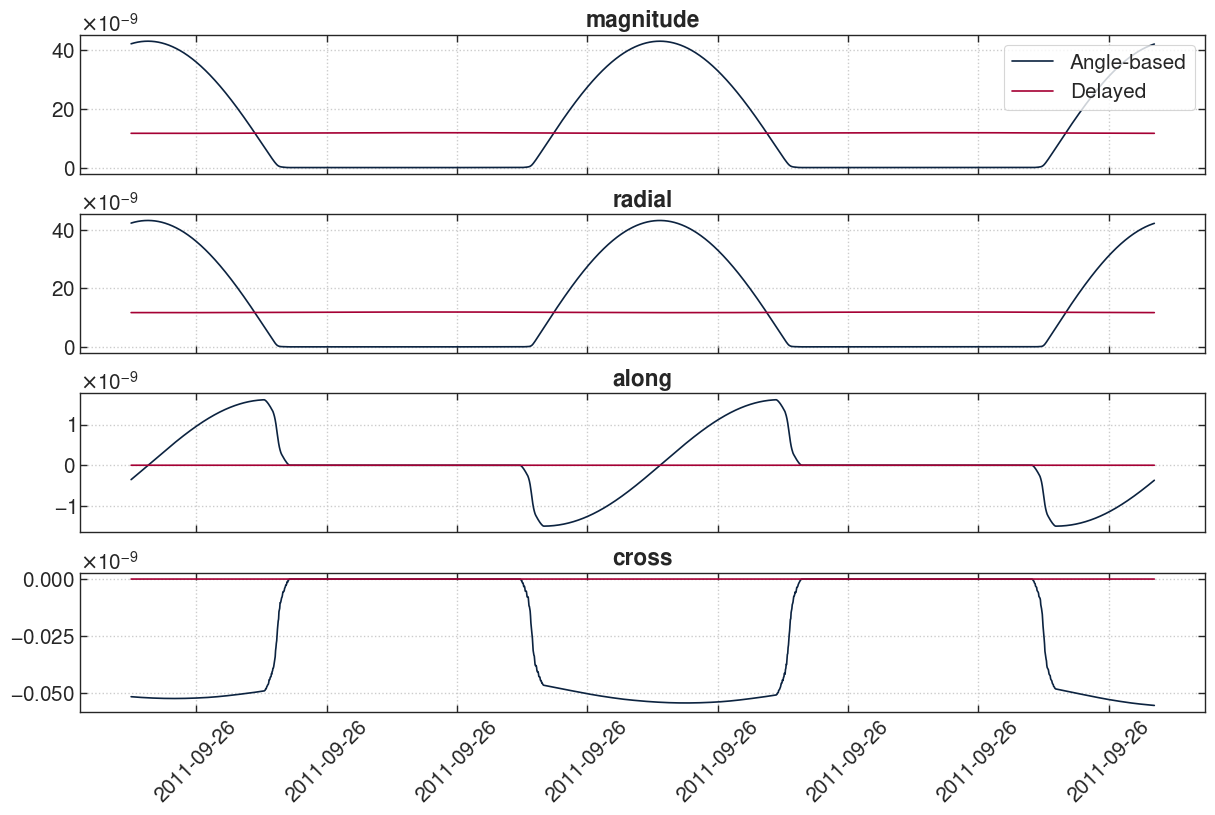

In [56]:
plot_thermal_type("2011 SEP 26")

Delayed model has constant radial acceleration and no cross/along acceleration since emissivity is constant.

### Albedo vs thermal radiation

In [57]:
def plot_albedo_vs_thermal(start_date):
    df_albedo = get_contrib_run("DLAM1", "NoThermal", "Cannonball", start_date)
    df_thermal = get_contrib_run("NoAlbedo", "AngleBased", "Cannonball", start_date)
    plot_accelerations([df_albedo, df_thermal], ["Albedo (DLAM-1)", "Thermal (angle-based)"])

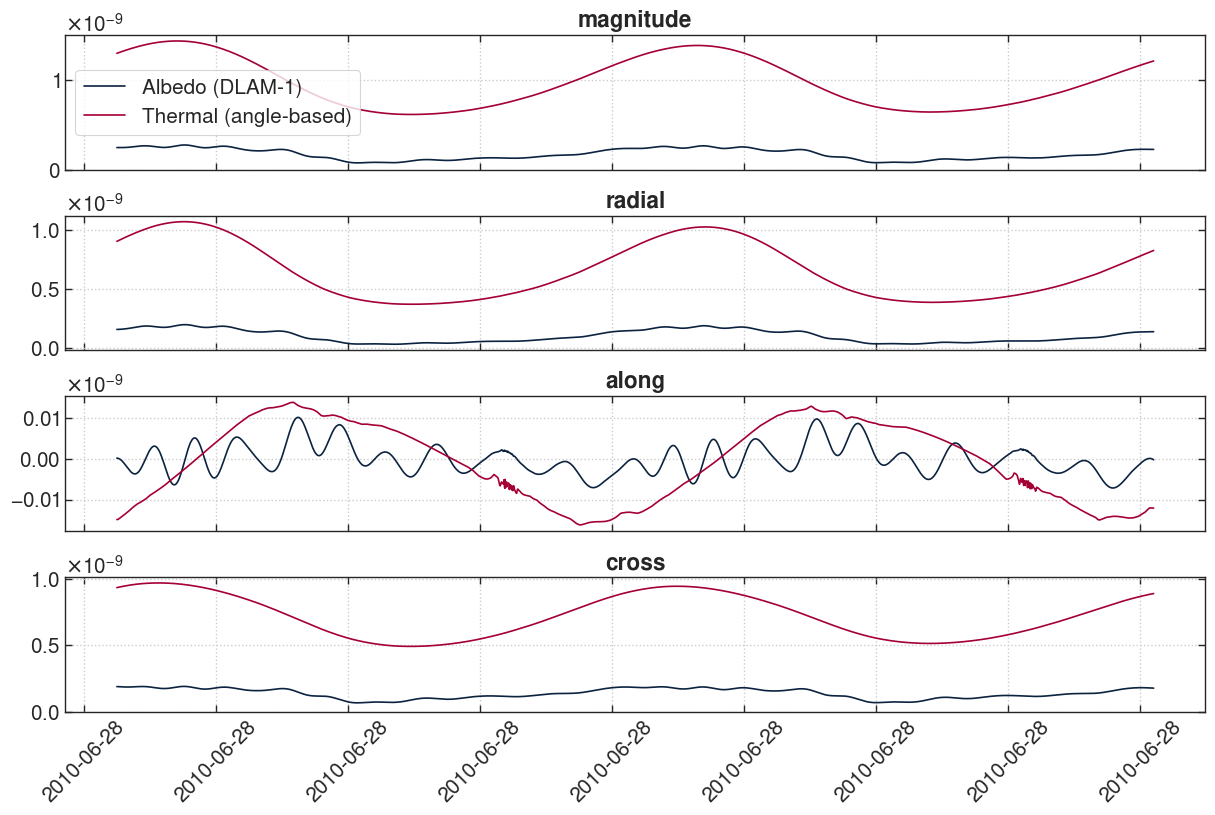

In [58]:
plot_albedo_vs_thermal("2010 JUN 28")

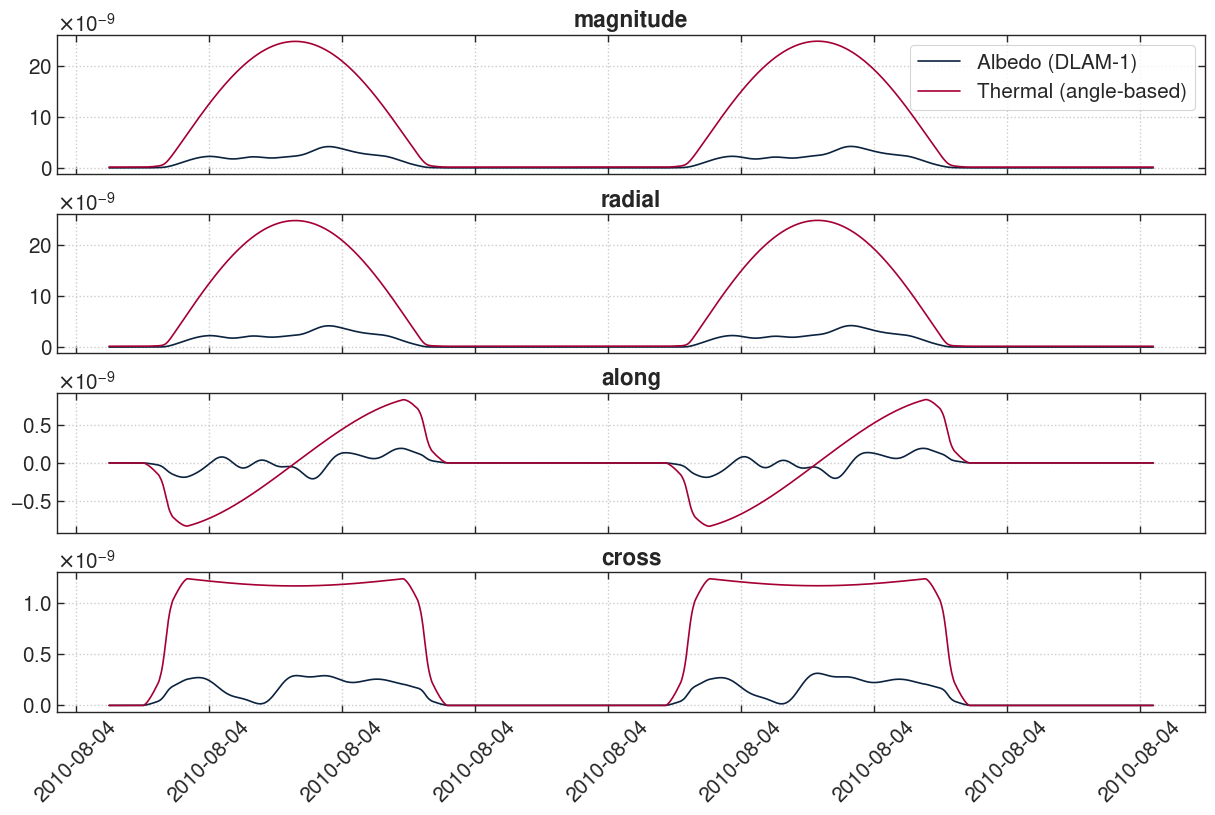

In [73]:
plot_albedo_vs_thermal("2010 AUG 4")

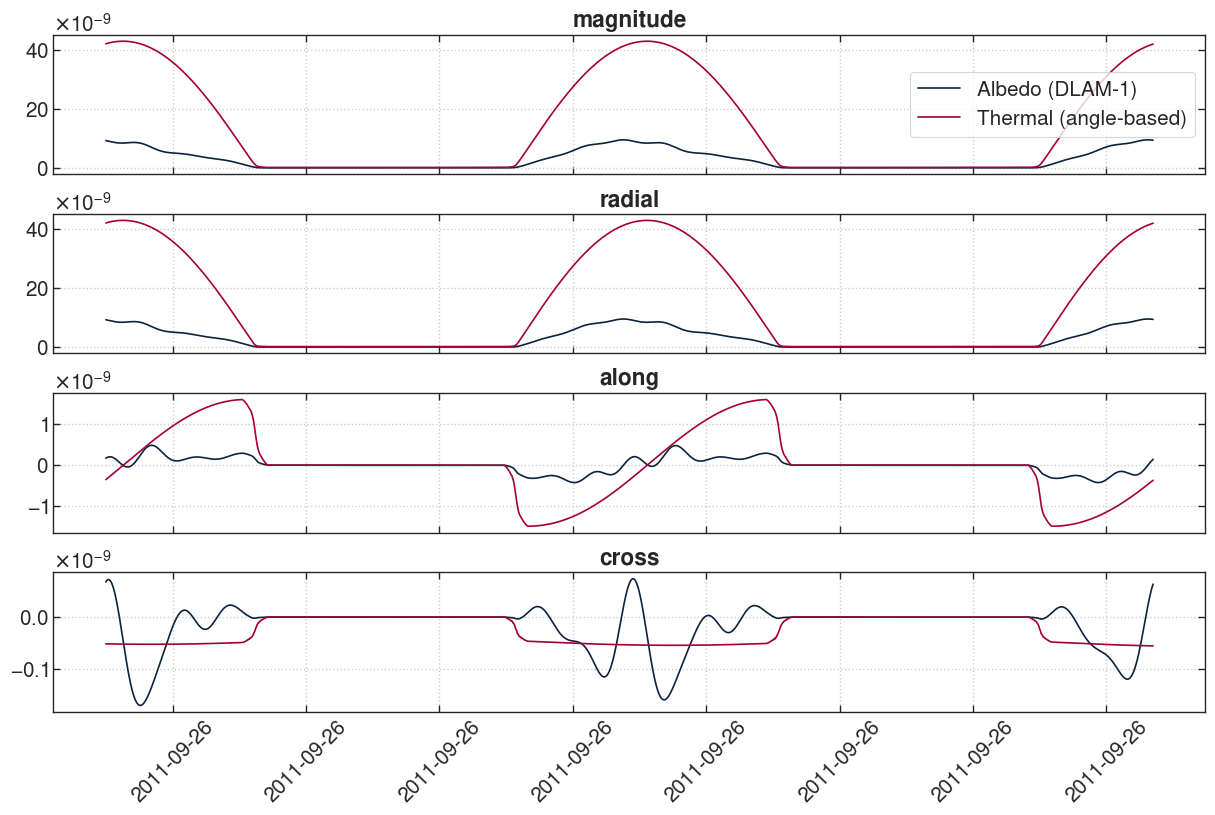

In [74]:
plot_albedo_vs_thermal("2011 SEP 26")

### Solar vs lunar

In [59]:
def plot_solar_vs_lunar(start_date):
    df = get_contrib_run("Constant", "AngleBased", "Cannonball", start_date)
    plot_accelerations([df, df], ["Solar", "Lunar"], ["sun", "moon"])

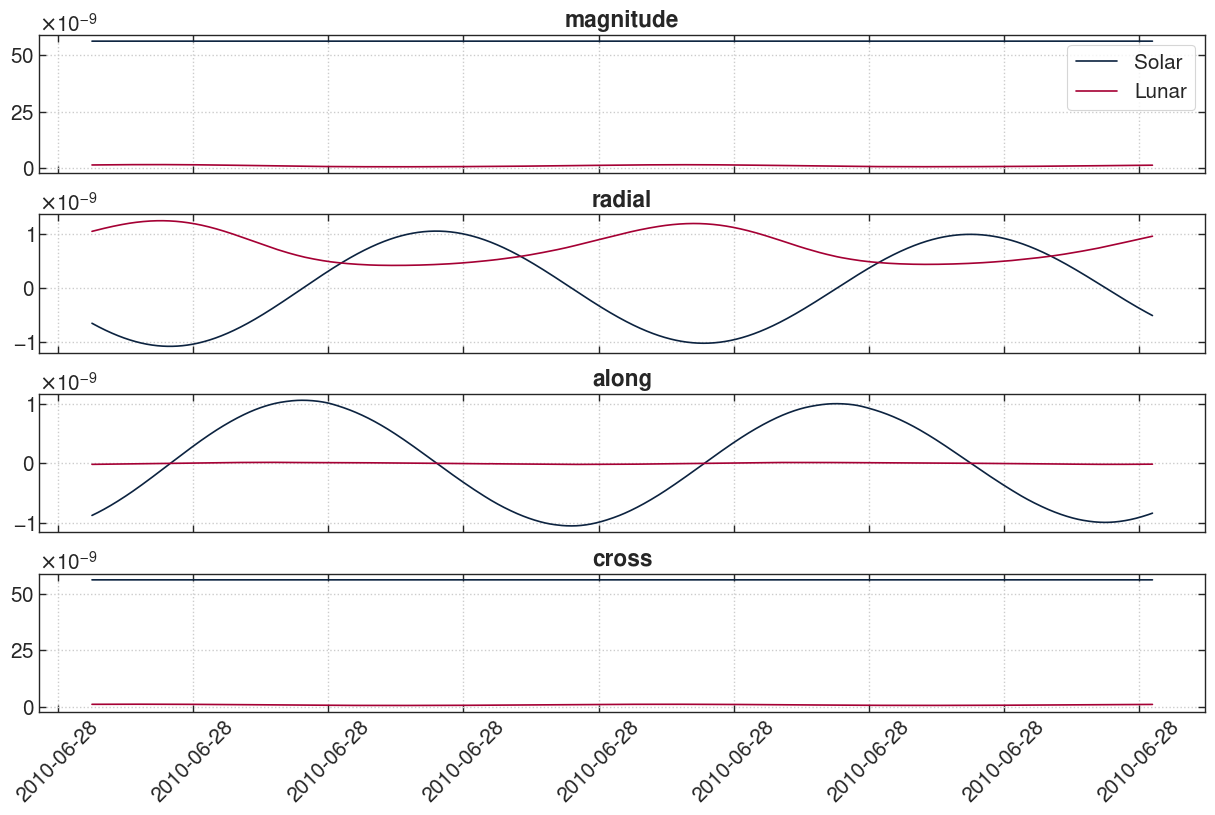

In [75]:
plot_solar_vs_lunar("2010 JUN 28")

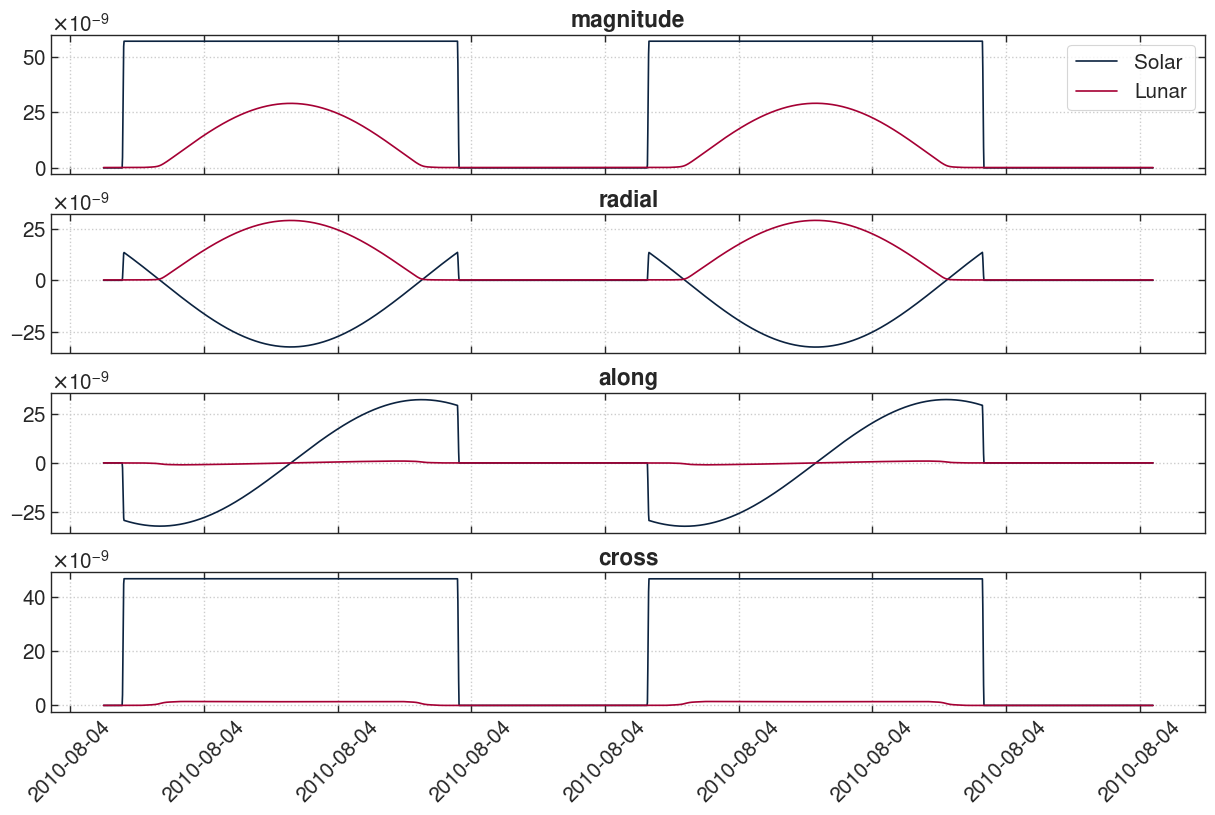

In [76]:
plot_solar_vs_lunar("2010 AUG 4")

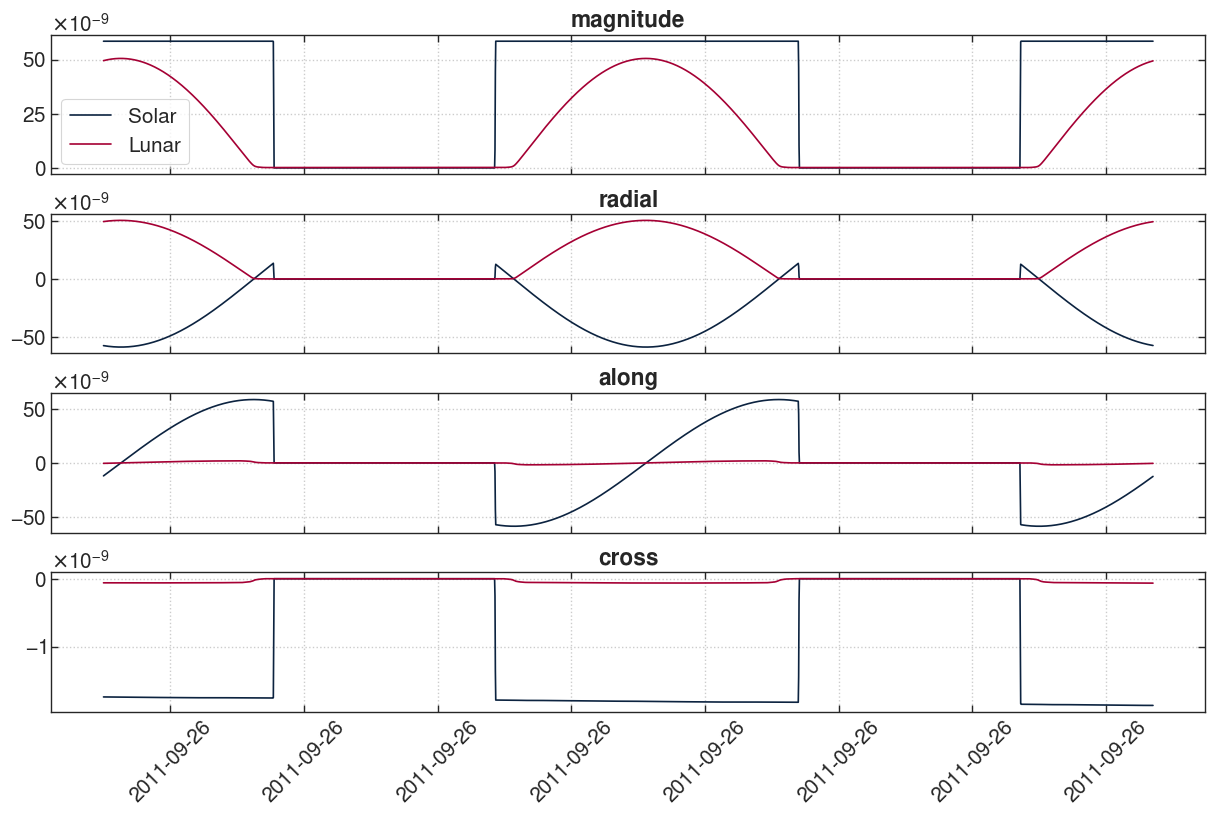

In [78]:
plot_solar_vs_lunar("2011 SEP 26")

# Effect of number of rings

In [62]:
results_folder_rings = Path("../results/number_of_panels_per_ring_test-2023-08-30T09-44-40-d4d3e/")
# results_folder_rings = Path("../results/number_of_panels_per_ring_test-2023-08-17T14-33-31-ffcd7/")
metadata_rings, runs_rings = load_pickled_simulation_results(results_folder_rings)

In [63]:
metadata_rings

id               hostname             start_timestamp  \
1   b949e  eudoxos.lr.tudelft.nl  2023-08-30T09:44:40.819095   
2   33464  eudoxos.lr.tudelft.nl  2023-08-30T09:44:40.819122   
3   f3209  eudoxos.lr.tudelft.nl  2023-08-30T09:44:40.819137   
4   f0298  eudoxos.lr.tudelft.nl  2023-08-30T09:44:40.819149   
5   8ce2d  eudoxos.lr.tudelft.nl  2023-08-30T09:44:40.819160   
6   08e8b  eudoxos.lr.tudelft.nl  2023-08-30T09:44:40.819172   
7   4027c  eudoxos.lr.tudelft.nl  2023-08-30T09:44:40.819184   
8   ef838  eudoxos.lr.tudelft.nl  2023-08-30T09:44:40.819198   
9   93492  eudoxos.lr.tudelft.nl  2023-08-30T09:44:40.819210   
10  11b81  eudoxos.lr.tudelft.nl  2023-08-30T09:44:40.819220   
11  8de52  eudoxos.lr.tudelft.nl  2023-08-30T09:44:40.819233   
12  f4838  eudoxos.lr.tudelft.nl  2023-08-30T09:44:40.819243   
13  792d5  eudoxos.lr.tudelft.nl  2023-08-30T09:44:40.819252   
14  16d1c  eudoxos.lr.tudelft.nl  2023-08-30T09:44:40.819260   
15  c4581  eudoxos.lr.tudelft.nl  2023-08-30T09:44:40.819269   
16  75d77  eudoxos.lr.tudelft.nl  2023-08-30T09:44:40.819277   
17  e8362  eudoxos.lr.tudelft.nl  2023-08-30T09:44:40.819284   
18  abef5  eudoxos.lr.tudelft.nl  2023-08-30T09:44:40.819293   
19  af369  eudoxos.lr.tudelft.nl  2023-08-30T09:44:40.819301   
20  56217  eudoxos.lr.tudelft.nl  2023-08-30T09:44:40.819315   
21  dc1ef  eudoxos.lr.tudelft.nl  2023-08-30T09:44:40.819324   
22  f5a6d  eudoxos.lr.tudelft.nl  2023-08-30T09:44:40.819335   
23  9f4dc  eudoxos.lr.tudelft.nl  2023-08-30T09:44:40.819344   
24  e121c  eudoxos.lr.tudelft.nl  2023-08-30T09:44:40.819351   
25  43312  eudoxos.lr.tudelft.nl  2023-08-30T09:44:40.819359   
26  355b2  eudoxos.lr.tudelft.nl  2023-08-30T09:44:40.819367   
27  cd39b  eudoxos.lr.tudelft.nl  2023-08-30T09:44:40.819375   
28  ccab5  eudoxos.lr.tudelft.nl  2023-08-30T09:44:40.819383   
29  543be  eudoxos.lr.tudelft.nl  2023-08-30T09:44:40.819395   
30  dfa1b  eudoxos.lr.tudelft.nl  2023-08-30T09:44:40.819421   
31  46edc  eudoxos.lr.tudelft.nl  2023-08-30T09:44:40.819430   

                                             save_dir      simulation_start  \
1   /home2/dominik/dev/hpb-project/results/number_...  2010 AUG 26 06:00:00   
2   /home2/dominik/dev/hpb-project/results/number_...  2010 AUG 26 06:00:00   
3   /home2/dominik/dev/hpb-project/results/number_...  2010 AUG 26 06:00:00   
4   /home2/dominik/dev/hpb-project/results/number_...  2010 AUG 26 06:00:00   
5   /home2/dominik/dev/hpb-project/results/number_...  2010 AUG 26 06:00:00   
6   /home2/dominik/dev/hpb-project/results/number_...  2010 AUG 26 06:00:00   
7   /home2/dominik/dev/hpb-project/results/number_...  2010 AUG 26 06:00:00   
8   /home2/dominik/dev/hpb-project/results/number_...  2010 AUG 26 06:00:00   
9   /home2/dominik/dev/hpb-project/results/number_...  2010 AUG 26 06:00:00   
10  /home2/dominik/dev/hpb-project/results/number_...  2010 AUG 26 06:00:00   
11  /home2/dominik/dev/hpb-project/results/number_...  2010 AUG 26 06:00:00   
12  /home2/dominik/dev/hpb-project/results/number_...  2010 AUG 26 06:00:00   
13  /home2/dominik/dev/hpb-project/results/number_...  2010 AUG 26 06:00:00   
14  /home2/dominik/dev/hpb-project/results/number_...  2010 AUG 26 06:00:00   
15  /home2/dominik/dev/hpb-project/results/number_...  2010 AUG 26 06:00:00   
16  /home2/dominik/dev/hpb-project/results/number_...  2010 AUG 26 06:00:00   
17  /home2/dominik/dev/hpb-project/results/number_...  2010 AUG 26 06:00:00   
18  /home2/dominik/dev/hpb-project/results/number_...  2010 AUG 26 06:00:00   
19  /home2/dominik/dev/hpb-project/results/number_...  2010 AUG 26 06:00:00   
20  /home2/dominik/dev/hpb-project/results/number_...  2010 AUG 26 06:00:00   
21  /home2/dominik/dev/hpb-project/results/number_...  2010 AUG 26 06:00:00   
22  /home2/dominik/dev/hpb-project/results/number_...  2010 AUG 26 06:00:00   
23  /home2/dominik/dev/hpb-project/results/number_...  2010 AUG 26 06:00:00   
24  /home2/dominik/dev/hpb-project/results/number_...  2010 AU

In [64]:
def get_dfs_rings(albedo):
    idxs = metadata_rings[
        (metadata_rings["albedo_distribution_moon"] == albedo)
    ]
    dfs = {
        len(row.number_of_panels_per_ring_moon): runs_rings[row.Index] for row in idxs.itertuples()
    }
    return dict(sorted(dfs.items(), key=lambda item: item[0]))

In [65]:
def plot_convergence_magnitude(dfs, labels):
    fig, ax = plt.subplots(1, 1, figsize=(7, 6), sharex="all")

    dfs = list(dfs)
    for i, df in enumerate(dfs):
        dfs[i] = trim_df(df, datetime(2010, 8, 26, 6, 57), datetime(2010, 8, 26, 8, 50))

    cmap = matplotlib.colormaps["Blues"](np.linspace(0.3, 1, len(dfs)))

    for df, label, color in zip(dfs, list(labels), cmap):
        ax.plot(get_revolutions_index(df), df["irr_moon"], label=f"{label} rings", c=color)

    ax.set_title("Irradiance")
    ax.legend()

    ax.tick_params(axis='x', labelrotation=45)
    # ax.set_ylim([min(0, ax.get_ylim()[0]), ax.get_ylim()[1]])
    
    format_plot(major_grid=True)

In [66]:
def plot_convergence_error(dfs, labels):
    fig, ax = plt.subplots(1, 1, figsize=(7, 6), sharex="all")

    dfs = list(dfs)
    for i, df in enumerate(dfs):
        dfs[i] = trim_df(df, datetime(2010, 8, 26, 6, 57), datetime(2010, 8, 26, 8, 50))

    df_ref = dfs[-1]

    cmap = matplotlib.colormaps["Blues"](np.linspace(0.3, 1, len(dfs)))

    for df, label, color in zip(dfs[:-1], list(labels)[:-1], cmap):
        # df = df.iloc[idx_start:idx_end]
        ax.plot(get_revolutions_index(df), (df["irr_moon"] - df_ref["irr_moon"]).abs(), label=f"{label} rings", c=color)

    ax.set_title("Irradiance absolute difference to highest resolution")
    ax.legend()

    ax.tick_params(axis='x', labelrotation=45)
    ax.set_yscale("log")
    # ax.set_ylim([min(0, ax.get_ylim()[0]), ax.get_ylim()[1]])
    
    format_plot(major_grid=True)

In [67]:
def plot_convergence_error_relative(dfs, labels):
    fig, ax = plt.subplots(1, 1, figsize=(7, 6), sharex="all")

    dfs = list(dfs)
    for i, df in enumerate(dfs):
        dfs[i] = trim_df(df, datetime(2010, 8, 26, 6, 57), datetime(2010, 8, 26, 8, 50))

    df_ref = dfs[-1]

    cmap = matplotlib.colormaps["Blues"](np.linspace(0.3, 1, len(dfs)))

    for df, label, color in zip(dfs[:-1], list(labels)[:-1], cmap):
        ax.plot(get_revolutions_index(df), (df["irr_moon"] - df_ref["irr_moon"]).abs() / df_ref["irr_moon"], label=f"{label} rings", c=color)

    ax.set_title("Irradiance relative difference to highest resolution")
    ax.legend()

    ax.tick_params(axis='x', labelrotation=45)
    ax.set_yscale("log")
    # ax.set_ylim([min(0, ax.get_ylim()[0]), ax.get_ylim()[1]])
    
    format_plot(major_grid=True)

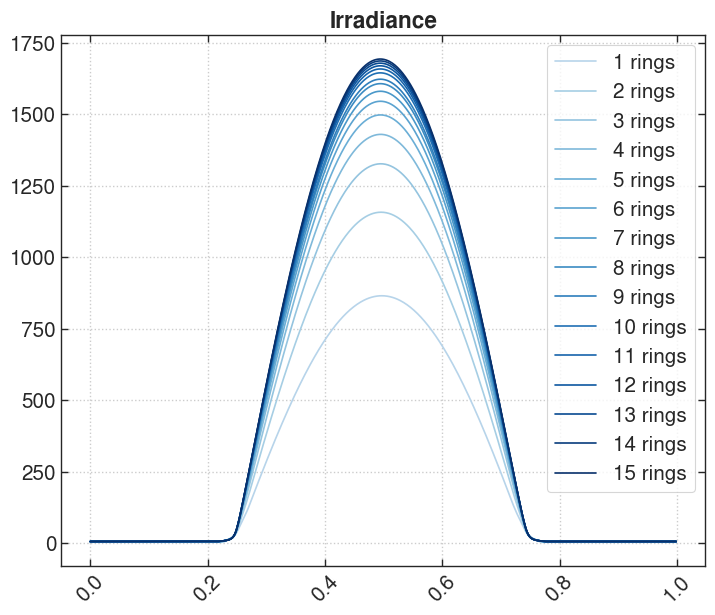

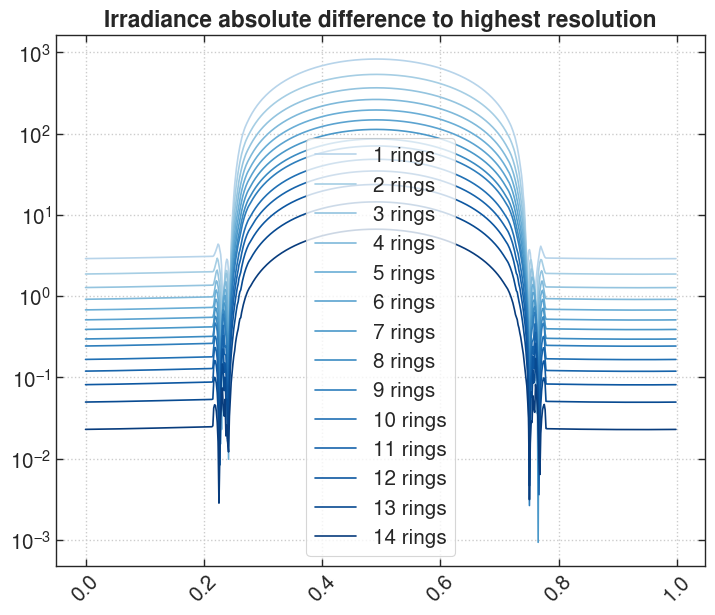

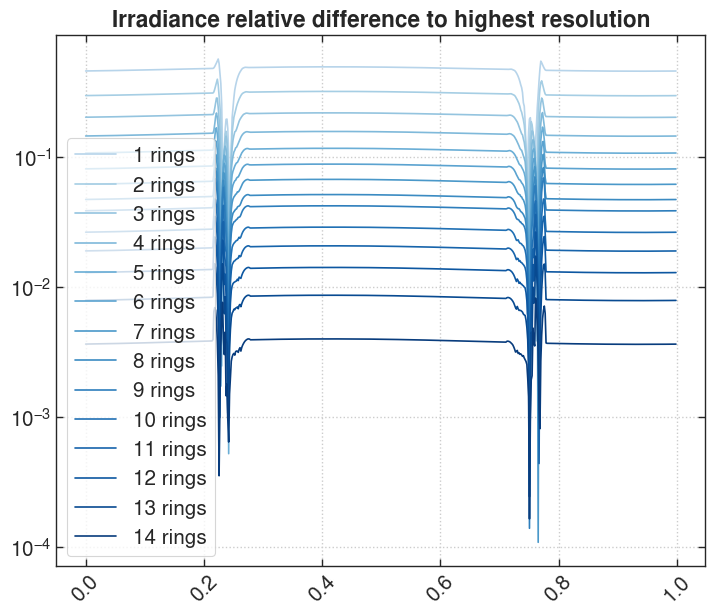

In [68]:
dfs_convergence = get_dfs_rings("Constant")
plot_convergence_magnitude(dfs_convergence.values(), dfs_convergence.keys())
plot_convergence_error(dfs_convergence.values(), dfs_convergence.keys())
plot_convergence_error_relative(dfs_convergence.values(), dfs_convergence.keys())

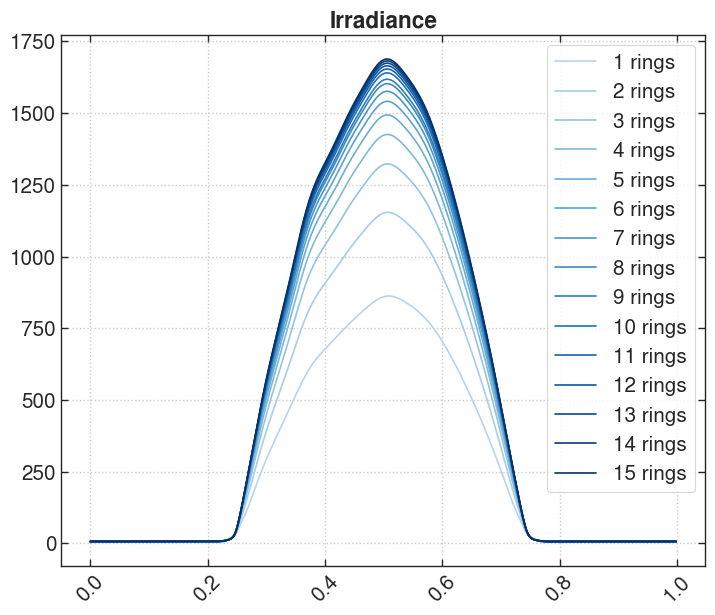

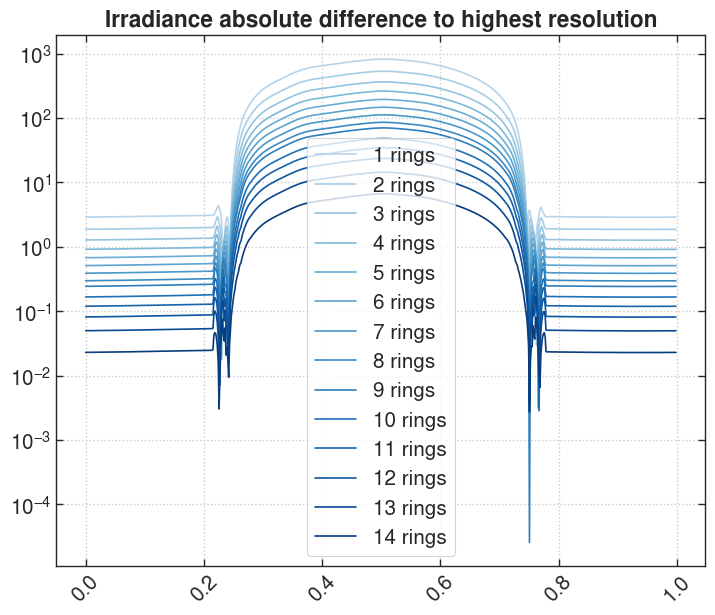

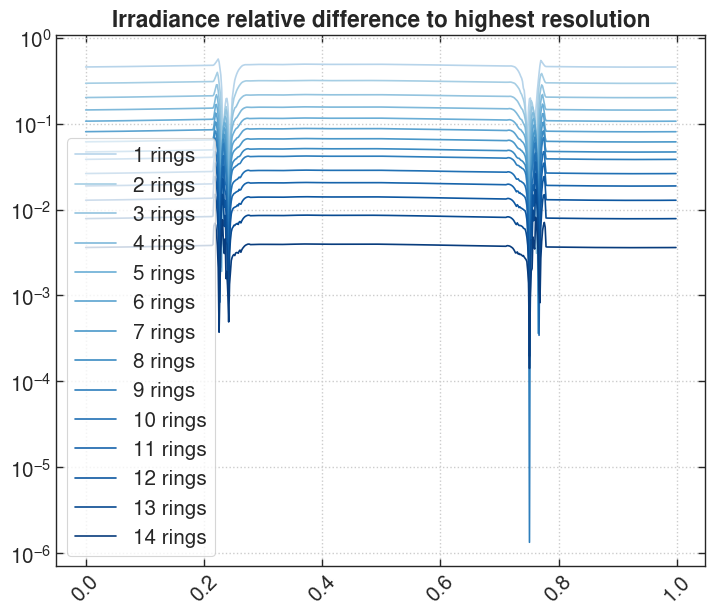

In [69]:
dfs_convergence = get_dfs_rings("DLAM1")
plot_convergence_magnitude(dfs_convergence.values(), dfs_convergence.keys())
plot_convergence_error(dfs_convergence.values(), dfs_convergence.keys())
plot_convergence_error_relative(dfs_convergence.values(), dfs_convergence.keys())

8 rings (error 8.2%) are required to bring the error below 10% at all times. The largest relative errors occur when crossing the terminator, however, at which point the accelerations are small in any case. To bring the peak error below 10%, only 6 panels (peak error 8.7%) are needed.